In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [ ]:
"""%%bash
pip3 install pennylane==0.28.0"""

'%%bash\npip3 install pennylane==0.28.0'

In [ ]:
"""%%bash
pip3 install gymnasium"""

'%%bash\npip3 install gymnasium'

In [ ]:
import gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import gym.spaces
from gym.envs.registration import register
from gym.envs import toy_text

class ShortestPathFrozenLake(toy_text.frozen_lake.FrozenLakeEnv):
	def __init__(self, **kwargs):
		super(ShortestPathFrozenLake, self).__init__(**kwargs)

		self.nS = self.nrow * self.ncol
		self.nA = 4
		for state in range(self.nS): # for all states
			for action in range(self.nA): # for all actions
				my_transitions = []
				for (prob, next_state, _, is_terminal) in self.P[state][action]:
					row = next_state // self.ncol
					col = next_state - row * self.ncol
					tile_type = self.desc[row, col]
					if tile_type == b'H':
						reward = -1.0
					elif tile_type == b'G':
						reward = 10.
					else:
						reward = -0.05

					my_transitions.append((prob, next_state, reward, is_terminal))
				self.P[state][action] = my_transitions


class BinaryWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super(BinaryWrapper, self).__init__(env)
        self.bits = int(np.ceil(np.log2(env.observation_space.n)))
        self.observation_space = gym.spaces.MultiBinary(self.bits)

    def observation(self, obs):
        binary = map(float, "{0:b}".format(int(obs)).zfill(self.bits))
        return np.array(list(binary))

# class FL(gym.ObservationWrapper):
#     def __init__(self, env):
#         super().__init__(env)
#         self.observation_space = gym.spaces.MultiBinary(16)

#     def observation(self, obs):
#         obsi = np.zeros(16)
#         obsi[obs] = 1
#         return obsi


register(
        id='FrozenLake-VA', # name given to this new environment
        entry_point=__name__ + ':ShortestPathFrozenLake', # env entry point
        kwargs={'map_name': '4x4', 'is_slippery': False} # argument passed to the env
)
env = gym.make('FrozenLake-VA')
env = BinaryWrapper(env)


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cpu")

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment FrozenLake-VA
  logger.warn(f"Overriding environment {spec.id}")


In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [ ]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 100
GAMMA = 0.99
EPS_START = 1.
EPS_END = 0.001
EPS_DECAY = 0.99
TAU = 0.01
LR = 1e-3


# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state = env.reset()
n_observations = len(state)


policy_net = DQN(4, 4).to(device)
target_net = DQN(4, 4).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.RMSprop(policy_net.parameters(), lr=LR)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    """eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)"""
    eps_threshold = max(
            EPS_END, EPS_END +
            (EPS_START - EPS_END) *
            EPS_DECAY**steps_done)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_rewards = []


def plot_durations(show_result=False):
    plt.figure(1)
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(rewards_t.numpy())
    # Take 100 episode averages and plot them too
    if len(rewards_t) >= 10:
        means = rewards_t.unfold(0, 10, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(9), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [ ]:
def optimize_model():
    #print(1)
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    #print(2)
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    #print(3)
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    #print(4)
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    #print(5)

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    #print(6)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    #print(7)
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 10)
    optimizer.step()

Complete


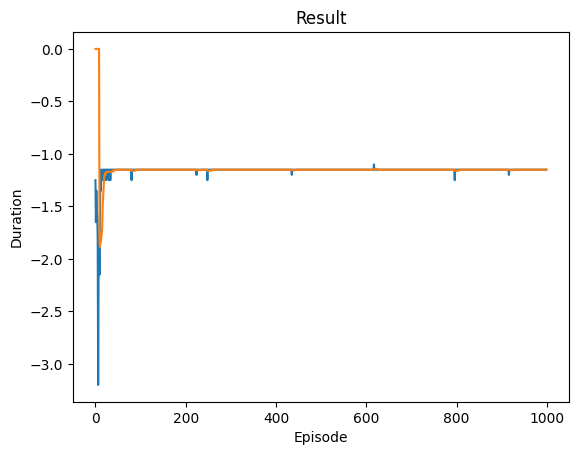

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
num_episodes = 1000

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    tot_rewards = 0
    steps = 0
    done = False
    while not done:
        action = select_action(state)
        steps += 1
        observation, reward, terminated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        tot_rewards += reward
        done = terminated

        if done:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        if steps % 10 == 0:
            optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_rewards.append(tot_rewards)
            print(f"Episode {i_episode} : {tot_rewards}")
            plot_durations()
            break
    #print(f"Episode {i_episode}, Rewards : {tot_rewards}")

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [ ]:
new_env = gym.make("FrozenLake-v1", render_mode="rgb_array", is_slippery = False)
new_env = FL(new_env)

In [ ]:


for i_episode in range(10):
    # Initialize the environment and get it's state
    state = new_env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    test_rewards = 0
    done = False
    steps = 0
    while not done:
        action = select_action(state)
        steps += 1
        observation, reward, terminated, _ = new_env.step(action.item())
        reward = torch.tensor([reward], device=device)
        test_rewards += reward
        done = terminated

        if done:
            break
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        state = next_state

    print(f"Episode : {i_episode}, Reward = {test_rewards}, Steps = {steps}")


new_env.close()


Episode : 0, Reward = tensor([1.]), Steps = 6
Episode : 1, Reward = tensor([1.]), Steps = 6
Episode : 2, Reward = tensor([1.]), Steps = 6
Episode : 3, Reward = tensor([1.]), Steps = 6
Episode : 4, Reward = tensor([1.]), Steps = 6
Episode : 5, Reward = tensor([1.]), Steps = 6
Episode : 6, Reward = tensor([1.]), Steps = 6
Episode : 7, Reward = tensor([1.]), Steps = 6
Episode : 8, Reward = tensor([1.]), Steps = 6
Episode : 9, Reward = tensor([1.]), Steps = 6


In [ ]:
torch.save(policy_net.state_dict(), 'p_state_dict.pt')
torch.save(target_net.state_dict(), 't_state_dict.pt')

"""import pickle

file = open('agents3', 'wb')
arr = [trainer.exploration_decay, trainer.exploration_initial_eps, trainer.exploration_final_eps]
"""

"import pickle\n\nfile = open('agents3', 'wb')\narr = [trainer.exploration_decay, trainer.exploration_initial_eps, trainer.exploration_final_eps]\n"